In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import glob


In [59]:
train_dir = Path("/Users/prasantpoudel/Desktop/skin/front/data/train/")
train_filepaths = list(train_dir.glob(r'**/*.*'))

test_dir = Path("/Users/prasantpoudel/Desktop/skin/front/data/test/")
test_filepaths = list(test_dir.glob(r'**/*.*'))


In [60]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [61]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

In [62]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 9605

Number of different labels: 2

Labels: ['malignant' 'benign']


In [63]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 9605 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [65]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/Users/prasantpoudel/Desktop/skin/front/data/model/model_resnet.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=0.5, verbose=5,min_lr=0.001)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
301/301 [==============================] - ETA: 0s - loss: 1.4895 - accuracy: 0.8878
Epoch 1: val_loss improved from inf to 0.19735, saving model to /Users/prasantpoudel/Desktop/skin/front/data/model/model_resnet.h5
301/301 [==============================] - 260s 854ms/step - loss: 1.4895 - accuracy: 0.8878 - val_loss: 0.1973 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 2/50
301/301 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9238
Epoch 2: val_loss improved from 0.19735 to 0.19292, saving model to /Users/prasantpoudel/Desktop/skin/front/data/model/model_resnet.h5
301/301 [==============================] - 277s 919ms/step - loss: 0.2101 - accuracy: 0.9238 - val_loss: 0.1929 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 3/50
301/301 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9435
Epoch 3: val_loss did not improve from 0.19292
301/301 [==============================] - 257s 854ms/step - loss: 0.1514 - accuracy: 0.9435 - val_loss

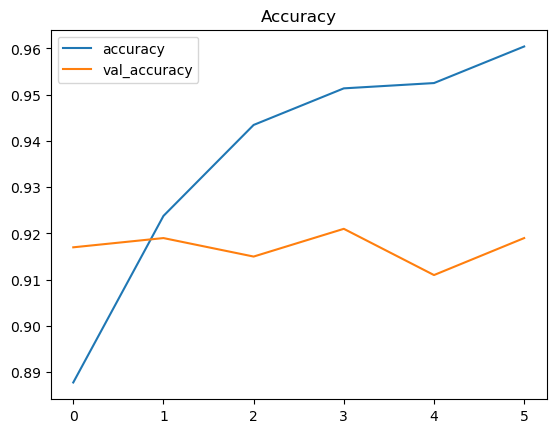

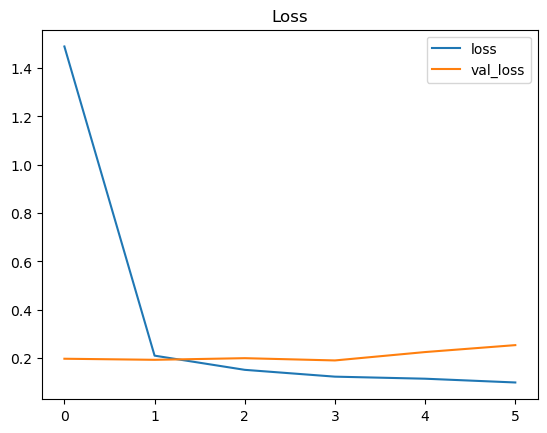

In [66]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.savefig('loss-graph.png')
plt.show()

In [13]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the pre-trained model
model = tf.keras.models.load_model('front_model_resnet.h5')

1/1 [==============================] - 1s 1s/step
The image is classified as non cancer


In [14]:
# Load the binary image
img = Image.open('melanoma_9879.jpg')
img = img.resize((224, 224))  # Resize the image to match the model input size
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Perform the classification
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("The image is classified as cancer")
    print(prediction[0][0])
else:
    print("The image is classified as non cancer")

1/1 [==============================] - 0s 52ms/step
The image is classified as non cancer
